In [124]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import docx
import os

# extras
from wordcloud import WordCloud
import nltk
from rake_nltk import Rake

# warnings
import warnings
warnings.filterwarnings('ignore')

## INITIAL SETUP

### Employee Information

In [125]:
# import employee list
employeeDF = pd.read_excel("task1/EmployeeRecords.xlsx")

employeeDF.head()

,LastName,FirstName,BirthDate,BirthCountry,Gender,CitizenshipCountry,CitizenshipBasis,CitizenshipStartDate,PassportCountry,PassportIssueDate,PassportExpirationDate,CurrentEmploymentType,CurrentEmploymentTitle,CurrentEmploymentStartDate,EmailAddress,MilitaryServiceBranch,MilitaryDischargeType,MilitaryDischargeDate
0,Bramar,Mat,1981-12-19,Tethys,Male,Tethys,BirthNation,1981-12-19,Tethys,2007-12-12,2017-12-11,Administration,Assistant to CEO,2005-07-01,Mat.Bramar@gastech.com.kronos,NaN,NaN,NaT
1,Ribera,Anda,1975-11-17,Tethys,Female,Tethys,BirthNation,1975-11-17,Tethys,2009-06-15,2019-06-14,Administration,Assistant to CFO,2009-10-30,Anda.Ribera@gastech.com.kronos,NaN,NaN,NaT
2,Pantanal,Rachel,1984-08-22,Tethys,Female,Tethys,BirthNation,1984-08-22,Tethys,2013-06-13,2023-06-12,Administration,Assistant to CIO,2013-10-01,Rachel.Pantanal@gastech.com.kronos,NaN,NaN,NaT
3,Lagos,Linda,1980-01-26,Tethys,Female,Tethys,BirthNation,1980-01-26,Tethys,2009-11-01,2019-10-31,Administration,Assistant to COO,2010-02-01,Linda.Lagos@gastech.com.kronos,NaN,NaN,NaT
4,Mies Haber,Ruscella,1964-04-26,Kronos,Female,Kronos,BirthNation,1964-04-26,NaN,NaT,NaT,Administration,Assistant to Engineering Group Manager,2003-04-02,Ruscella.Mies.Haber@gastech.com.kronos,ArmedForcesOfKronos,HonorableDischarge,1984-10-01


In [126]:
#see all columns and data types
employeeDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   LastName                    54 non-null     object        
 1   FirstName                   54 non-null     object        
 2   BirthDate                   54 non-null     datetime64[ns]
 3   BirthCountry                54 non-null     object        
 4   Gender                      54 non-null     object        
 5   CitizenshipCountry          54 non-null     object        
 6   CitizenshipBasis            54 non-null     object        
 7   CitizenshipStartDate        54 non-null     datetime64[ns]
 8   PassportCountry             33 non-null     object        
 9   PassportIssueDate           33 non-null     datetime64[ns]
 10  PassportExpirationDate      33 non-null     datetime64[ns]
 11  CurrentEmploymentType       54 non-null     object        
 

In [127]:
# check for null values
employeeDF.isna().sum()

LastName                       0
FirstName                      0
BirthDate                      0
BirthCountry                   0
Gender                         0
CitizenshipCountry             0
CitizenshipBasis               0
CitizenshipStartDate           0
PassportCountry               21
PassportIssueDate             21
PassportExpirationDate        21
CurrentEmploymentType          0
CurrentEmploymentTitle         0
CurrentEmploymentStartDate     0
EmailAddress                   0
MilitaryServiceBranch         27
MilitaryDischargeType         27
MilitaryDischargeDate         27
dtype: int64

In [128]:
# create helpful additional columns
employeeDF['FullName'] = employeeDF.FirstName + " " + employeeDF.LastName

### Employee Resume and Bio's

In [129]:
# pull resume and bio word documents into a dataframe
pathResume = "C://Users/court/Desktop/COMP4449/task1/resumes/"
dirList = os.listdir(pathResume)

names = []
content = []

for i in dirList:
    x = re.sub(r"\..*", "", i)
    x = re.sub(r"\-", "", x)
    x = re.sub(r"([A-Z])", r" \1", x).split()
    x = x[1:]
    x = " ".join(x)

    doc = docx.Document(pathResume + i)
    paras = [p.text for p in doc.paragraphs if p.text]
    paras = " ".join(paras)
    paras = re.sub(r"\t", "", paras)
    paras = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[]^_`{|}~"""), ' ', paras)
    paras = re.sub(r'[^x00-x7f]', r' ', paras)


    names.append(x)
    content.append(paras)

resumeDF = pd.DataFrame(list(zip(names, content)), columns=["FullName", "Resume"])


In [130]:
resumeDF.head()

,FullName,Resume
0,Ada Campo,Ada Campo Corrente Chief Information Officer M...
1,Ingrid Barranco,Ingrid Barranco Chief Financial Officer Ms In...
2,Orhan Strum,Orhan Strum Chief Operating Officer Mr Strum ...
3,Sten Sanjorge Jr,Sten Sanjorge Jr President CEO GASTech Teth...
4,Willem Vasco,Willem Vasco Pais Environmental Safet Advisor...


### Email Headers

In [131]:
# import email headers
emailDF = pd.read_csv("C://Users/court/Desktop/COMP4449/task1/email headers.csv", encoding="cp1252")


In [132]:
# Replace Name with email address
fromList = []

for i in emailDF['From']:

    if i == 'Sten.Sanjorge.Jr.@gastech.com.tethys':
        x = employeeDF.loc[employeeDF['EmailAddress'] == "Sten.Sanjorge Jr.@gastech.com.kronos"]

        fromList.append(x['FullName'].values[0])

    else:
        x = employeeDF.loc[employeeDF['EmailAddress'] == i]

        fromList.append(x['FullName'].values[0])

emailDF['FromName'] = fromList


In [133]:
# replace to emails with name list
fullTo = []

for email in emailDF['To']:

    eList = email.split(", ")

    toList = []

    for j in eList:

        if j == 'Sten.Sanjorge.Jr.@gastech.com.tethys':
            x = employeeDF.loc[employeeDF['EmailAddress'] == "Sten.Sanjorge Jr.@gastech.com.kronos"]

            toList.append(x['FullName'].values[0])

        else:
            x = employeeDF.loc[employeeDF['EmailAddress'] == j]

            toList.append(x['FullName'].values[0])

    fullTo.append(", ".join(toList))

emailDF['ToName'] = fullTo


In [134]:
emailDF.head()

,From,To,Date,Subject,FromName,ToName
0,Sven.Flecha@gastech.com.kronos,"Isak.Baza@gastech.com.kronos, Lucas.Alcazar@ga...",01/06/2014,GT-SeismicProcessorPro Bug Report,Sven Flecha,"Isak Baza, Lucas Alcazar"
1,Kanon.Herrero@gastech.com.kronos,"Felix.Resumir@gastech.com.kronos, Hideki.Cocin...",01/06/2014,Inspection request for site,Kanon Herrero,"Felix Resumir, Hideki Cocinaro, Inga Ferro, Va..."
2,Bertrand.Ovan@gastech.com.kronos,"Emile.Arpa@gastech.com.kronos, Varro.Awelon@ga...",01/06/2014,New refueling policies - Effective February 1,Bertrand Ovan,"Emile Arpa, Varro Awelon, Dante Coginian, Albi..."
3,Valeria.Morlun@gastech.com.kronos,"Dante.Coginian@gastech.com.kronos, Albina.Hafo...",01/06/2014,Route suggestion for next shift,Valeria Morlun,"Dante Coginian, Albina Hafon, Benito Hawelon, ..."
4,Mat.Bramar@gastech.com.kronos,"Rachel.Pantanal@gastech.com.kronos, Lars.Azada...",01/06/2014,Upcoming birthdays,Mat Bramar,"Rachel Pantanal, Lars Azada, Felix Balas, Isan..."


### Email Interactions

In [135]:
interactDF = pd.DataFrame(emailDF.iloc[:, [4,5]])
interactDF = interactDF.groupby(['FromName'])['ToName'].apply(list).reset_index()

keyss = interactDF['FromName'].tolist()
valss = sorted(interactDF['ToName'].tolist())

interDict = {}
for key in keyss:
    for value in valss:
        interDict[key] = value
        valss.remove(value)
        break

### Historical Documents

In [136]:
# create path for each document
pathHist = "C://Users/court/Desktop/COMP4449/task1/HistoricalDocuments/"
dirList2 = os.listdir(pathHist)


for i in dirList2:

    x = re.sub(r"\..*", "", i)
    x = re.sub(r"([A-Z])", r" \1", x).split()
    x = x[:2]
    x = "".join(x)
    x = "historical" + x + "DF"

    doc = docx.Document(pathHist + i)
    
    paras = [p.text for p in doc.paragraphs if p.text]
    paras = " ".join(paras)

    r = Rake(punctuations = [')', '(', ',', ':', '),', ').', '.'])
    r.extract_keywords_from_text(paras)

    if x == "historical10YearDF":
        tenDF = pd.DataFrame(r.get_ranked_phrases_with_scores(), columns=['score', 'phrase'])
    else:
        fiveDF = pd.DataFrame(r.get_ranked_phrases_with_scores(), columns=['score', 'phrase'])

In [137]:
tenDF.loc[tenDF.score>3].head()

,score,phrase
0,72.000000,extended families ; however increased media aw...
1,56.916667,wfa project manager joclyn reynolds began form...
2,51.033333,august 18 1998 ten - year old juliana vann
3,44.333333,city council held several closed - door sessions
4,28.000000,20 - year old son


In [138]:
fiveDF.loc[fiveDF.score>3].head()

,score,phrase
0,32.105263,10 - year - old girl
1,30.666667,lorenzo di stefano lorenzo di stefano
2,29.605263,28 - year - old nephew
3,25.100000,dynamic speaker whose charismatic leadership a...
4,23.714286,recently authored several scientific articles


### Articles

In [211]:
# create path for each document
pathArticle = "C://Users/court/Desktop/COMP4449/task1/articles/"
dirList3 = os.listdir(pathArticle)

cont20 = []
cont21 = []

for i in dirList3:

    x = re.sub(r"\..*", "", i)

    with open(pathArticle + i) as f:
        contents = f.read()
        
        if '20 January 2014' in contents:
            cont20.append(contents)
            
        if '21 January 2014' in contents:
            cont21.append(contents)


## ANALYSIS

### Structure Of POK

In [139]:
for phrase in tenDF.phrase.loc[tenDF.score >= 3.142857]:
    print(phrase)


extended families ; however increased media awareness brought additional interest
wfa project manager joclyn reynolds began formal scientific testing
august 18 1998 ten - year old juliana vann
city council held several closed - door sessions
20 - year old son
gas drilling operations several kilometers upstream
june 2001 minister nespola died suddenly
kronos october 2005 kyrla halford kyrla
early 1997 certain elodis citizens convened
meeting took place outside range
original pok members began considering
gastech mining operations near elodis
remaining founding members would follow
pok across kronos began rising
october 2001 henk bodrogi stepped
government offered gastech following malfeasance
kronos government ; however
well - respected member
warhol - esque colors
bringing increasingly widespread awareness
1998 found high levels
underground methane deposit ignited
open right hand within
hyper acidic substrate removal
almost entirely dependent upon
july 1999 cesare nespola
membership nu

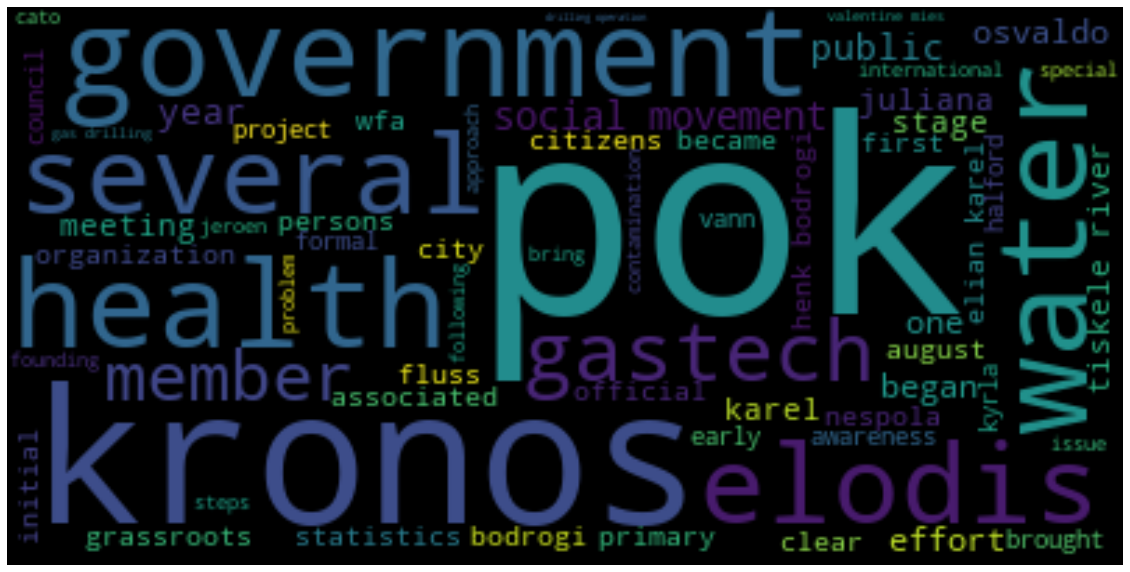

In [140]:
plt.figure(figsize=(20, 15))
wordcloud = WordCloud().generate(" ".join(tenDF.phrase.loc[tenDF.score > 3]))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

plt.show()

In [141]:
for phrase in fiveDF.phrase.loc[fiveDF.score > 3]:
    print(phrase)


10 - year - old girl
lorenzo di stefano lorenzo di stefano
28 - year - old nephew
dynamic speaker whose charismatic leadership abilities
recently authored several scientific articles
government - controlled tiskele bend fields
karel staged numerous peaceful environmental rallies
low - level government functionaries
broad - based pluralized movement
authors see three possible futures
pok agenda among general assembly members
movements may also end due
many small activist groups joined forces
energy - based economy
open right hand rising
hyper acidic substrate removal
hyper acidic substrate removal
conduct massive public education
pok members recruited since 2001
- educated young males
agrarian - based economy
wfa test results convinced osvaldo
growing expect rapid success
organized several peaceful pok rallies
200 - 300 people
current pok leader elian karel
pok protests changed markedly
cease include systematic suppression
enact stronger environmental laws
disaffected young male members

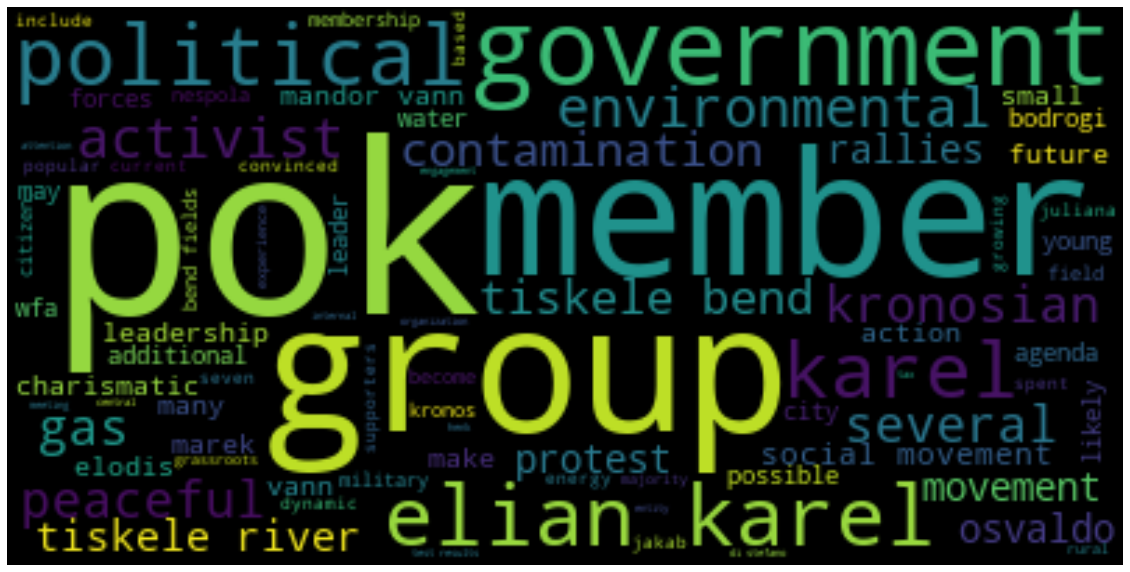

In [142]:
plt.figure(figsize=(20,15))
wordcloud = WordCloud().generate(" ".join(fiveDF.phrase.loc[fiveDF.score > 3]))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

plt.show()

#### Leaders

Henk Bodrogi chose Elian Karel, who recruited Silvia Marek. So the three potential leaders are Henk Bodrogi, Elian Krel, and Silvia Marek.

#### Extended Network

Some important POK members include:
- Lorenzo Di Stefano
- Isia Vann
- Mandor Vann
- Lucio Jakab
- Silvia Marek
- Valentine Mies
- Carmine Osvaldo
- Jeroen Karel
- Joreto Katell
- Yanick Cato
- Cesare Nespola

#### Structure Changes

Originally it was 7 members. It was a grassroots program wanting stricter environmental laws, which was backed by the government. Juliana Vann was killed due to toxicity pollution. She was related to some of the POK members and sparked an uproar, increasing the desire to join the Protectors of Kronos.

When Cesare Nespola, the health minister died, Henk Bodrogi stepped down and Elian Karel stepped up. POK started recruiting heavily, particularly young men. The Protectors of Kronos were still very peaceful but started to get involved with a lot of activism and protests. 

After Elian Karel died, Silvia Marek took over. The organization got a lot more criminal and was radicalizing it's new members. POK became very militious. 


#### Connections between POK & GAStech

First, we can look at employees with the same last names as known POK members.

In [143]:
lnList = employeeDF['FullName'].loc[employeeDF["LastName"].isin(['Vann', 'Stefano', 'Jakab', 'Marek', 'Mies', 'Osvaldo', 'Karel', 'Katell', 'Cato', 'Nespola'])].tolist()

lnList

['Henk Mies', 'Minke Mies', 'Hennie Osvaldo', 'Isia Vann', 'Edvard Vann']

Let's check which employees are born in Kronos

In [144]:
kronosList = employeeDF['FullName'].loc[employeeDF["BirthCountry"] == 'Kronos'].tolist()

kronosList

['Ruscella Mies Haber',
 'Carla Forluniau',
 'Cornelia Lais',
 'Emile Arpa',
 'Varro Awelon',
 'Dante Coginian',
 'Albina Hafon',
 'Benito Hawelon',
 'Claudio Hawelon',
 'Henk Mies',
 'Valeria Morlun',
 'Adan Morlun',
 'Cecilia Morluniau',
 'Irene Nant',
 'Dylan Scozzese',
 'Minke Mies',
 'Hennie Osvaldo',
 'Isia Vann',
 'Edvard Vann',
 'Loreto Bodrogi',
 'Inga Ferro']

Now we can check which employees started working at POK after 2009, which is when the second leader, Elian Karel, passed.

In [145]:
deathList = employeeDF['FullName'].loc[employeeDF["CurrentEmploymentStartDate"] >= '2009-01-01'].tolist()

deathList

['Anda Ribera',
 'Rachel Pantanal',
 'Linda Lagos',
 'Cornelia Lais',
 'Gustav Cazar',
 'Willem Vasco-Pais',
 'Emile Arpa',
 'Varro Awelon',
 'Albina Hafon',
 'Henk Mies',
 'Cecilia Morluniau',
 'Lucas Alcazar',
 'Sven Flecha',
 'Minke Mies',
 'Hennie Osvaldo',
 'Edvard Vann',
 'Loreto Bodrogi',
 'Hideki Cocinaro',
 'Inga Ferro']

Finally we can look employees in the security department, since that seems to be very suspicious.

In [146]:
securityList = employeeDF['FullName'].loc[employeeDF["CurrentEmploymentType"] >= 'Security'].tolist()

securityList


['Kanon Herrero',
 'Varja Lagos',
 'Stenig Fusil',
 'Minke Mies',
 'Hennie Osvaldo',
 'Isia Vann',
 'Edvard Vann',
 'Felix Resumir',
 'Loreto Bodrogi',
 'Hideki Cocinaro',
 'Inga Ferro']

Let's look at the names that were repeated. This will cut down our suspect list.

In [147]:
allSuspects = lnList + kronosList + deathList + securityList

dups = [x for i, x in enumerate(allSuspects) if x in allSuspects[:i]]

suspects = list(set(dups))

suspects


['Isia Vann',
 'Cecilia Morluniau',
 'Inga Ferro',
 'Cornelia Lais',
 'Albina Hafon',
 'Hideki Cocinaro',
 'Emile Arpa',
 'Loreto Bodrogi',
 'Minke Mies',
 'Edvard Vann',
 'Varro Awelon',
 'Henk Mies',
 'Hennie Osvaldo']

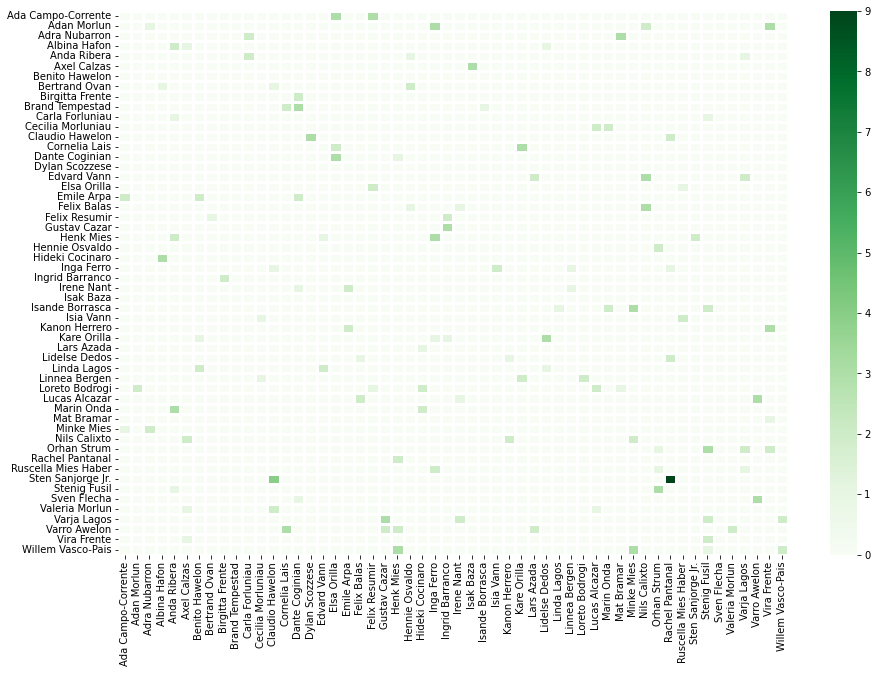

In [148]:
interMatrix = []

for name in interDict.keys():
    x = interDict[name]

    row = []

    for connect in interDict.keys():
        row.append(x.count(connect))

    interMatrix.append(row)

plt.figure(figsize=(15,10))
sns.heatmap(interMatrix, cmap="Greens", xticklabels=interDict.keys(), yticklabels=interDict.keys(), linewidths=3, linecolor='white')
plt.show()


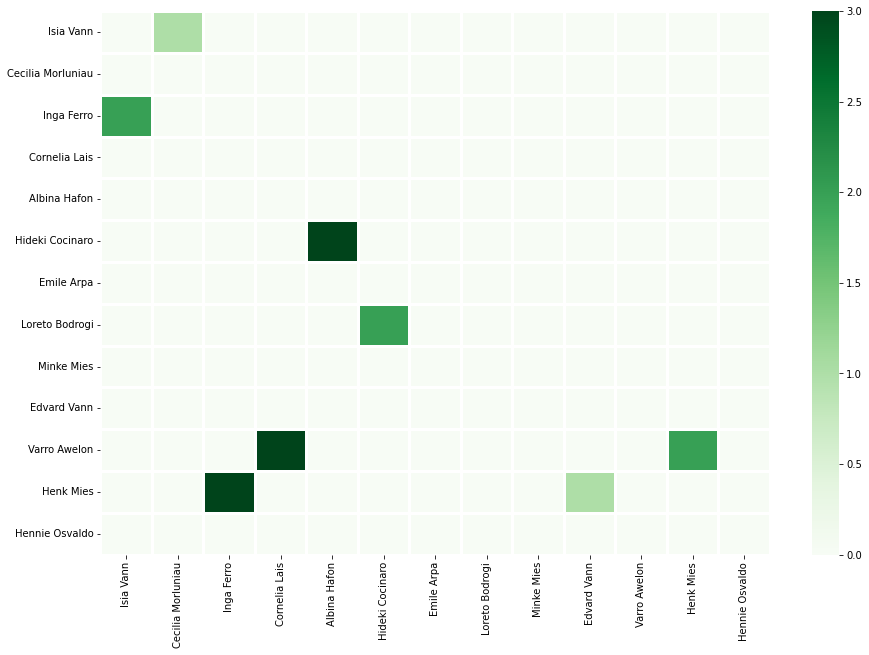

In [149]:
suspectMatrix = []

for name in suspects:
    x = interDict[name]

    row = []

    for connect in suspects:
        row.append(x.count(connect))

    suspectMatrix.append(row)

plt.figure(figsize=(15, 10))
sns.heatmap(suspectMatrix, cmap="Greens", xticklabels=suspects,
            yticklabels=suspects, linewidths=3, linecolor='white')
plt.show()


Considering Isia Vann is a know POV member and also works at GAStech, it's interesting to see the interaction between Isia and Inga Ferro. Additionally, there is a very strong connection between Henk Mies and Inga Ferro.

In [150]:
# email interaction plot

# who talks to who the most

employeeDF[employeeDF['FullName'].isin(suspects)]

,LastName,FirstName,BirthDate,BirthCountry,Gender,CitizenshipCountry,CitizenshipBasis,CitizenshipStartDate,PassportCountry,PassportIssueDate,PassportExpirationDate,CurrentEmploymentType,CurrentEmploymentTitle,CurrentEmploymentStartDate,EmailAddress,MilitaryServiceBranch,MilitaryDischargeType,MilitaryDischargeDate,FullName
6,Lais,Cornelia,1991-07-07,Kronos,Female,Kronos,BirthNation,1991-07-07,NaN,NaT,NaT,Administration,Assistant to Security Group Manager,2011-12-22,Cornelia.Lais@gastech.com.kronos,ArmedForcesOfKronos,GeneralDischarge,2011-10-01,Cornelia Lais
26,Arpa,Emile,1992-10-01,Kronos,Male,Kronos,BirthNation,1992-10-01,NaN,NaT,NaT,Facilities,Janitor,2013-03-18,Emile.Arpa@gastech.com.kronos,ArmedForcesOfKronos,GeneralDischarge,2012-10-01,Emile Arpa
27,Awelon,Varro,1986-05-05,Kronos,Male,Kronos,BirthNation,1986-05-05,NaN,NaT,NaT,Facilities,Janitor,2012-10-22,Varro.Awelon@gastech.com.kronos,ArmedForcesOfKronos,GeneralDischarge,2006-10-01,Varro Awelon
29,Hafon,Albina,1987-06-14,Kronos,Female,Kronos,BirthNation,1987-06-14,NaN,NaT,NaT,Facilities,Truck Driver,2009-09-12,Albina.Hafon@gastech.com.kronos,ArmedForcesOfKronos,GeneralDischarge,2007-10-01,Albina Hafon
32,Mies,Henk,1984-09-23,Kronos,Male,Kronos,BirthNation,1984-09-23,NaN,NaT,NaT,Facilities,Truck Driver,2013-07-12,Henk.Mies@gastech.com.kronos,ArmedForcesOfKronos,HonorableDischarge,2004-10-01,Henk Mies
35,Morluniau,Cecilia,1988-09-02,Kronos,Female,Kronos,BirthNation,1988-09-02,NaN,NaT,NaT,Facilities,Truck Driver,2009-04-30,Cecilia.Morluniau@gastech.com.kronos,ArmedForcesOfKronos,GeneralDischarge,2008-10-01,Cecilia Morluniau
46,Mies,Minke,1992-11-19,Kronos,Male,Kronos,BirthNation,1992-11-19,NaN,NaT,NaT,Security,Perimeter Control,2013-05-22,Minke.Mies@gastech.com.kronos,ArmedForcesOfKronos,GeneralDischarge,2011-10-01,Minke Mies
47,Osvaldo,Hennie,1988-05-31,Kronos,Male,Kronos,BirthNation,1988-05-31,NaN,NaT,NaT,Security,Perimeter Control,2011-06-07,Hennie.Osvaldo@gastech.com.kronos,ArmedForcesOfKronos,GeneralDischarge,2010-10-01,Hennie Osvaldo
48,Vann,Isia,1986-12-13,Kronos,Male,Kronos,BirthNation,1986-12-13,NaN,NaT,NaT,Security,Perimeter Control,2007-12-14,Isia.Vann@gastech.com.kronos,ArmedForcesOfKronos,GeneralDischarge,2007-10-01,Isia Vann
49,Vann,Edvard,1991-03-18,Kronos,Male,Kronos,BirthNation,1991-03-18,NaN,NaT,NaT,Security,Perimeter Control,2013-08-15,Edvard.Vann@gastech.com.kronos,ArmedForcesOfKronos,HonorableDischarge,2011-10-01,Edvard Vann


In [162]:
# of the people talking the most, what are the email headers associated with those people
subs = emailDF[['FromName', 'Subject']].loc[emailDF['FromName'].isin(suspects)]

for i in subs.values:
    print(i)

['Loreto Bodrogi' 'Plants']
['Albina Hafon' 'RE: New refueling policies - Effective February 1']
['Loreto Bodrogi' 'RE: Patrol schedule changes']
['Loreto Bodrogi' 'RE: Plants']
['Loreto Bodrogi' 'RE: Plants']
['Hennie Osvaldo' 'Concert tickets']
['Cornelia Lais' 'RE: Craft night']
['Cecilia Morluniau' 'Supplies']
['Varro Awelon' "RE: Don't text and drive!"]
['Albina Hafon' 'RE: Route suggestion for next shift']
['Cecilia Morluniau' 'RE: Supplies']
['Cecilia Morluniau' 'RE: Facilities preparations for VIP visit']
['Isia Vann' 'This weekend?']
['Inga Ferro' 'Late for meeting']
['Isia Vann' 'Karoake night']
['Varro Awelon' 'RE: Traffic advisory for today']
['Henk Mies' 'RE: List of repairs needed']
['Inga Ferro' 'RE: Late for meeting']
['Cecilia Morluniau' 'RE: Traffic advisory for today']
['Cecilia Morluniau' 'RE: Traffic advisory for today']
['Cornelia Lais' 'RE: Dress for success - Dress to impress']
['Hideki Cocinaro' 'No hurry']
['Cecilia Morluniau' 'RE: Traffic advisory for today']

Albina Hafon


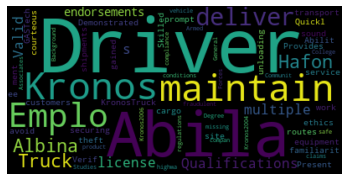

Cornelia Lais


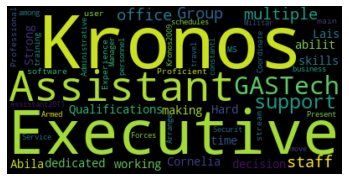

Emile Arpa


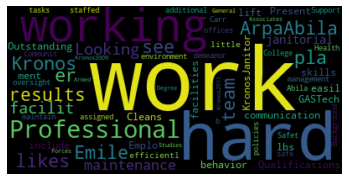

Hideki Cocinaro


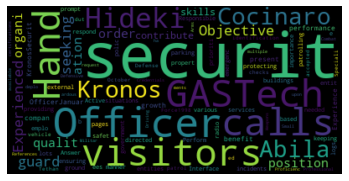

Isia Vann


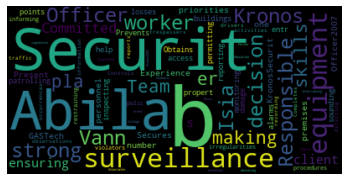

Loreto Bodrogi


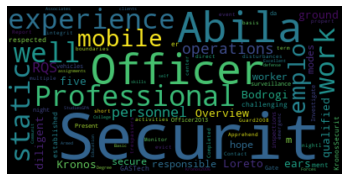

Minke Mies


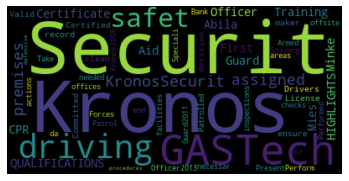

In [164]:
# analysis of key words in resumes and bios

for row in resumeDF.values:

    if row[0] in suspects:

        wordcloud = WordCloud().generate(row[1])
        print(row[0])
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")

        plt.show()


### TIMELINE

In [212]:
for event in cont20:
    if 'kidnapping' in event:
        print(event)

The Abila Post
ON THE SCENE BLOG
By Haneson Ngohebo
20 January 2014

2021 UPDATE - A Kronos Government official who asked not to be identified but was present at the government reception has gone on the record stating, "Investigators are working around the clock to ensure that the kidnapped GAStech employees are found and that the perpetrators are brought to justice."
This is the first confirmation that today's events surrounding GAStech - Kronos are in fact a kidnapping. With fourteen individuals still unaccounted for, at this point, the assumption is that all are the victims of a kidnapping.
No group has come forward yet to claim responsibility nor have any demands been made.
Kronos Star
Breaking: Emergency at GAStech Headquarters Building [Updates]
Cato Rossini, Marcella Trapani
20 January 2014

Update, 5:50 PM:  According to a GAStech employee, the GAStech executives left the building after their meeting this morning and were headed to the reception at the capitol building.  When a

In [214]:
for event in cont20:
    if 'jet' in event:
        print(event)


Centrum Sentinel
VOICES - a blog approximately that what is important to people

20 January 2014

2232 - There are relationships that the civil employees of the airport have confirmed the arrival of a classified jet from Tethys.  Several passengers have left in an attending limousine.  The reporter they have followed the limousine, that he has guided directly to the centers of the police of Abila. 20 gen. 2014
Centrum Sentinel
VOICES - a blog approximately that what is important to people

20 January 2014

1744 - The means relationships are coming in how much a sure number of employ you of GAStech have been rob to you.  The identity of the passengers on the mystery jet that has left today more in advance payment from the airport of Abila remains disowned. 20 gen. 2014
Tethys News
To break off itself: The emergency to GAStech quarters the construction [modernizations]

20 January 2014

Modernization, 6:10 PM:  The executive jet of GAStech according to as reported it has arrived in Tethy

In [215]:
for event in cont20:
    if 'fire alarm' in event:
        print(event)


Homeland Illumination
VOICES - a blog about what is important to the people
Maha Salo
20 January 2014

1018 - A fire alarm has gone off at GAStech headquarters.  People are evacuating the building, and so far no sign of Sanjorge or his executive staff.   Officials have asked reporters to move away from the building to allow the fire department access.  This has the flavor of yet another media ploy to avoid confrontation from the people of Kronos.  20 Jan 2014
The Abila Post
ON THE SCENE BLOG
By Haneson Ngohebo
20 January 2014

1158 UPDATE - The Abila Fire Department finished a thorough search of the GAStech building finding evidence of fire. At 11:45 AM they gave the all clear for the GAStech employees to re-enter the building. An AFD spokesman stated that the fire alarm appears to be a false alarm and that it was not a part of a planned fire drill.
The spokesman declined to answer whether or not the fire alarm was intentionally pulled.
The Abila Post
ON THE SCENE BLOG
By Haneson Ngohe

In [220]:
for event in cont20:
    if 'helicopter' in event:
        print(event)


Tethys News
To break off itself: The emergency to GAStech quarters the construction [modernizations]

20 January 2014

Modernization, 10:20:  It employs you of GAStech evacuate the sheets of the helicopter and the construction from the roof of the construction.
Kronos Star
Breaking: Emergency at GAStech Headquarters Building [Updates]
Cato Rossini, Marcella Trapani
20 January 2014

Update, 10:20 AM:  GAStech employees evacuate the building and a helicopter leaves from the roof of the building.


In [213]:
for event in cont21:
    if 'kidnapping' in event:
        print(event)


Modern Rubicon
ON SCENE BLOG

21 January 2014

the 1245 MODERNIZATION - I REDEEM DEMANDS FROM POK - the protections of Kronos has freed a supporting responsibility of declaration of the kidnapping of employs you of GAStech that they demand I redeem $20 million.
International Times
GASTech Employees Kidnapped in Kronos

21 January 2014  1405
Fourteen employees feared kidnapped in Kronos by a radical environmental terrorist group during a corporate gathering. 
Fourteen employees, including possibly five executive officers, are feared kidnapped yesterday by the "Protectors of Kronos".  Reported missing includes: GAStech President and CEO Sten Sanjorge Jr,CFO Ingrid Barranco, CIO Ada Campo-Corrente, COO Orhan Strum, and Environmental Officer Willem Vasco-Pais.
Local news organizations have received a ransom note from the POK claiming responsibility and demanding $20 Million from the company.  It is possible additional demands are forthcoming.
Sanjorge and the others disappeared following a

In [216]:
for event in cont21:
    if 'GAStech' in event:
        print(event)


Modern Rubicon
ON SCENE BLOG

21 January 2014

the 1245 MODERNIZATION - I REDEEM DEMANDS FROM POK - the protections of Kronos has freed a supporting responsibility of declaration of the kidnapping of employs you of GAStech that they demand I redeem $20 million.
Centrum Sentinel
VOICES - a blog approximately that what is important to people

21 January 2014

0715 - Welcome to continuous filling of the passing of several employs you of GAStech.  That what is known:  The police has announced that fourteen employ you of GAStech are disappeared a moment yesterday morning.  The civil employees from Tethys - corporative civil employees probable you of GAStech - the arrived late past night in a classified jet and have gone directly to the centers of the police of Abila.  A fire fire signaler has yesterday played morning to the centers of GAStech-Kronos approximately to the 10:15.  No fire has been identified, neither it was a bomb since taken of some means had marked.  Not there are the inform

January 20th was GAStech's annual corporate meeting with a Kronos Government reception to follow. 

- 10:00 AM - Fire alarm goes off. Abila Fire Department arrive at GAStech.
- 10:20 AM - Helicopter leaves from the roof of GAStech during the evacuation.
- 10:30 AM - Executives were unable to be reached due to security protocols but were supposed to head to the capitol building.
- 10:50 AM - A GAStech employee stated the fire alarm was pulled in response to a bomb threat.
- 3:40 PM - Several men wearing black were spotted in the building before the fire alarm was pulled.
- 5:48 PM - Two private jets with a total of 14-16 passengers between the two took off from the Abila Airport. One was headed for Rome, Italy. The other included Sten Sanjorge, Jr. and landed in Tethys.
- 7:00 PM - Edvard Vann questioned for 6 hours indicated POK might be involved. Denied his own connection to POK.
- 8:00 PM - Confirmed that 14 GAStech employees were kidnapped.


January 21st

- 9:00 AM - Police confirmed the number missing is actually 10, also announcing the CEO, Sten Sanjorge Jr., was safe in Tethys.
- 12:45 PM - Protectors of Kronos took responsibility for the kidnapping and demands a $20 Million ransom from Sanjorge Jr. 


In [219]:
# confirmed missing people
missing = ['Ingrid Barranco', 'Ada Campo-Corrente', 'Orhan Strum', 'Willem Vasco-Pais']

employeeDF[employeeDF['FullName'].isin(missing)]

,LastName,FirstName,BirthDate,BirthCountry,Gender,CitizenshipCountry,CitizenshipBasis,CitizenshipStartDate,PassportCountry,PassportIssueDate,PassportExpirationDate,CurrentEmploymentType,CurrentEmploymentTitle,CurrentEmploymentStartDate,EmailAddress,MilitaryServiceBranch,MilitaryDischargeType,MilitaryDischargeDate,FullName
20,Vasco-Pais,Willem,1975-03-18,Tethys,Male,Tethys,BirthNation,1975-03-18,Tethys,2011-11-26,2021-11-25,Executive,Environmental Safety Advisor,2010-06-05,Willem.Vasco-Pais@gastech.com.kronos,NaN,NaN,NaT,Willem Vasco-Pais
22,Barranco,Ingrid,1961-10-26,Tethys,Female,Tethys,BirthNation,1961-10-26,Tethys,2013-07-01,2023-06-30,Executive,SVP/CFO,2003-09-30,Ingrid.Barranco@gastech.com.kronos,NaN,NaN,NaT,Ingrid Barranco
23,Campo-Corrente,Ada,1951-11-26,Tethys,Female,Tethys,BirthNation,1951-11-26,Tethys,2013-07-14,2023-07-13,Executive,SVP/CIO,2004-10-05,Ada.Campo-Corrente@gastech.com.kronos,NaN,NaN,NaT,Ada Campo-Corrente
24,Strum,Orhan,1963-10-18,Asteria,Male,Tethys,ParentCitizenship,1963-10-18,Tethys,2011-06-02,2021-06-01,Executive,SVP/COO,2003-08-07,Orhan.Strum@gastech.com.kronos,NaN,NaN,NaT,Orhan Strum


In [217]:
# possible missing people

employeeDF[employeeDF['CitizenshipCountry'] == "Tethys"]

,LastName,FirstName,BirthDate,BirthCountry,Gender,CitizenshipCountry,CitizenshipBasis,CitizenshipStartDate,PassportCountry,PassportIssueDate,PassportExpirationDate,CurrentEmploymentType,CurrentEmploymentTitle,CurrentEmploymentStartDate,EmailAddress,MilitaryServiceBranch,MilitaryDischargeType,MilitaryDischargeDate,FullName
0,Bramar,Mat,1981-12-19,Tethys,Male,Tethys,BirthNation,1981-12-19,Tethys,2007-12-12,2017-12-11,Administration,Assistant to CEO,2005-07-01,Mat.Bramar@gastech.com.kronos,NaN,NaN,NaT,Mat Bramar
1,Ribera,Anda,1975-11-17,Tethys,Female,Tethys,BirthNation,1975-11-17,Tethys,2009-06-15,2019-06-14,Administration,Assistant to CFO,2009-10-30,Anda.Ribera@gastech.com.kronos,NaN,NaN,NaT,Anda Ribera
2,Pantanal,Rachel,1984-08-22,Tethys,Female,Tethys,BirthNation,1984-08-22,Tethys,2013-06-13,2023-06-12,Administration,Assistant to CIO,2013-10-01,Rachel.Pantanal@gastech.com.kronos,NaN,NaN,NaT,Rachel Pantanal
3,Lagos,Linda,1980-01-26,Tethys,Female,Tethys,BirthNation,1980-01-26,Tethys,2009-11-01,2019-10-31,Administration,Assistant to COO,2010-02-01,Linda.Lagos@gastech.com.kronos,NaN,NaN,NaT,Linda Lagos
7,Onda,Marin,1969-12-31,Tethys,Male,Tethys,BirthNation,1969-12-31,Tethys,2005-04-15,2015-04-14,Engineering,Drill Site Manager,2003-04-13,Marin.Onda@gastech.com.kronos,NaN,NaN,NaT,Marin Onda
8,Borrasca,Isande,1979-10-22,Tethys,Female,Tethys,BirthNation,1979-10-22,Tethys,2008-10-03,2018-10-02,Engineering,Drill Technician,2004-02-18,Isande.Borrasca@gastech.com.kronos,NaN,NaN,NaT,Isande Borrasca
9,Calzas,Axel,1975-09-13,Tethys,Male,Tethys,BirthNation,1975-09-13,Tethys,2012-01-31,2022-01-30,Engineering,Drill Technician,1997-07-17,Axel.Calzas@gastech.com.kronos,NaN,NaN,NaT,Axel Calzas
10,Orilla,Kare,1964-02-29,Tethys,Female,Tethys,BirthNation,1964-02-29,Tethys,2013-07-01,2023-06-30,Engineering,Drill Technician,2005-11-12,Kare.Orilla@gastech.com.kronos,NaN,NaN,NaT,Kare Orilla
11,Orilla,Elsa,1982-04-12,Tethys,Female,Tethys,BirthNation,1982-04-12,Tethys,2010-02-28,2020-02-27,Engineering,Drill Technician,2004-05-26,Elsa.Orilla@gastech.com.kronos,NaN,NaN,NaT,Elsa Orilla
12,Tempestad,Brand,1979-05-14,Tethys,Male,Tethys,BirthNation,1979-05-14,Tethys,2012-05-05,2022-05-04,Engineering,Drill Technician,2004-06-12,Brand.Tempestad@gastech.com.kronos,NaN,NaN,NaT,Brand Tempestad


### POSSIBLE EXPLANATIONS FOR KIDNAPPING

#### Hypothesis 1

After Juliana Vann’s death, while POK gained popularity, not much progress was made policy-wise. GAStech was never held accountable for their actions, and something needed to be done. Isia Vann had been working for GAStech for many years. After 2009, when Elian Karel took over, many POK members got jobs at GAStech to gain control within the company. All suspects worked together to ensure things went according to plan and they kidnapped employees from the ‘invading country’, Tethys. They let CEO, Sten Sanjorge Jr., make it out so that they could demand $20 Million in damages and finally hold GAStech accountable.

#### Hypothesis 2

Isia Vann, while being a longtime member of POK, was fed up with the way the organization was heading. Additionally, GAStech had a large activism group after them for their past mistakes. Working together, the CEO and Isia, along with other security personnel, devised a plan to throw POK under the bus and get them off their backs. The 10 ‘kidnapped’ employees were taken in the helicopter to a safe but unknown place – believing they were kidnapped, while the CEO escaped. Isia, working with POK, convinced them to take responsibility and demand a ransom, as many new radicalized members were out of control. This way, the police would put a firmer grasp on the unmanageable POK members, while letting GAStech pay for past mistakes but manage their reputation.